# Dependencies

In [ ]:
!pip install torchsummary

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
# Image processing
from PIL import Image
import cv2

#Exploratory Data Analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DL_Project_1/age_gender.csv')
df.shape

(23705, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [ ]:
df['pixels'] = df['pixels'].apply(lambda x:  np.reshape(np.array(x.split(), dtype="float32"), (48,48)))
df.shape

(23705, 5)

In [ ]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 20..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 21..."


In [ ]:
fig = px.histogram(df, x="age")
fig.update_layout(title_text='Age Histogram')
fig.show()

In [ ]:
eth_values_to_labels = { 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" }
gender_values_to_labels = { 0: "Male", 1: "Female" }

In [ ]:
df.ethnicity.value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [ ]:
fig = go.Figure([
    go.Bar(x=[eth_values_to_labels[i] for i in df.ethnicity.value_counts().index], 
           y=df.ethnicity.value_counts().values)
])
fig.update_layout(
    title_text='Count Plot Ethnicity',
    xaxis_title='Ethnicity',
    yaxis_title='Count'
)
fig.show()

In [ ]:
df.gender.value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [ ]:
fig = go.Figure([
    go.Bar(x=[gender_values_to_labels[i] for i in df.gender.value_counts().index], 
           y=df.gender.value_counts().values)
])
fig.update_layout(
    title_text='Count Plot Gender',
    xaxis_title='Gender',
    yaxis_title='Count'
)
fig.show()

In [ ]:
def plot_data(rows, cols, lower_value, upper_value):

    figure = plt.figure(figsize=(cols*3,rows*4))
    for i in range(1, cols*rows + 1):
        k = np.random.randint(lower_value,upper_value)
        figure.add_subplot(rows, cols, i) # adding sub plot

        gender = gender_values_to_labels[df.gender[k]]
        ethnicity = eth_values_to_labels[df.ethnicity[k]]
        age = df.age[k]
        
        im = df.pixels[k]
        # im = np.reshape(im, (48,48))
        plt.imshow(im, cmap='gray')
        plt.axis('off')
        plt.title(f'Gender:{gender}\nAge:{age}\nEthnicity:{ethnicity}')

    plt.tight_layout()
    plt.show()

#Different Faces on the basis of Age, Ethnicity and Gender

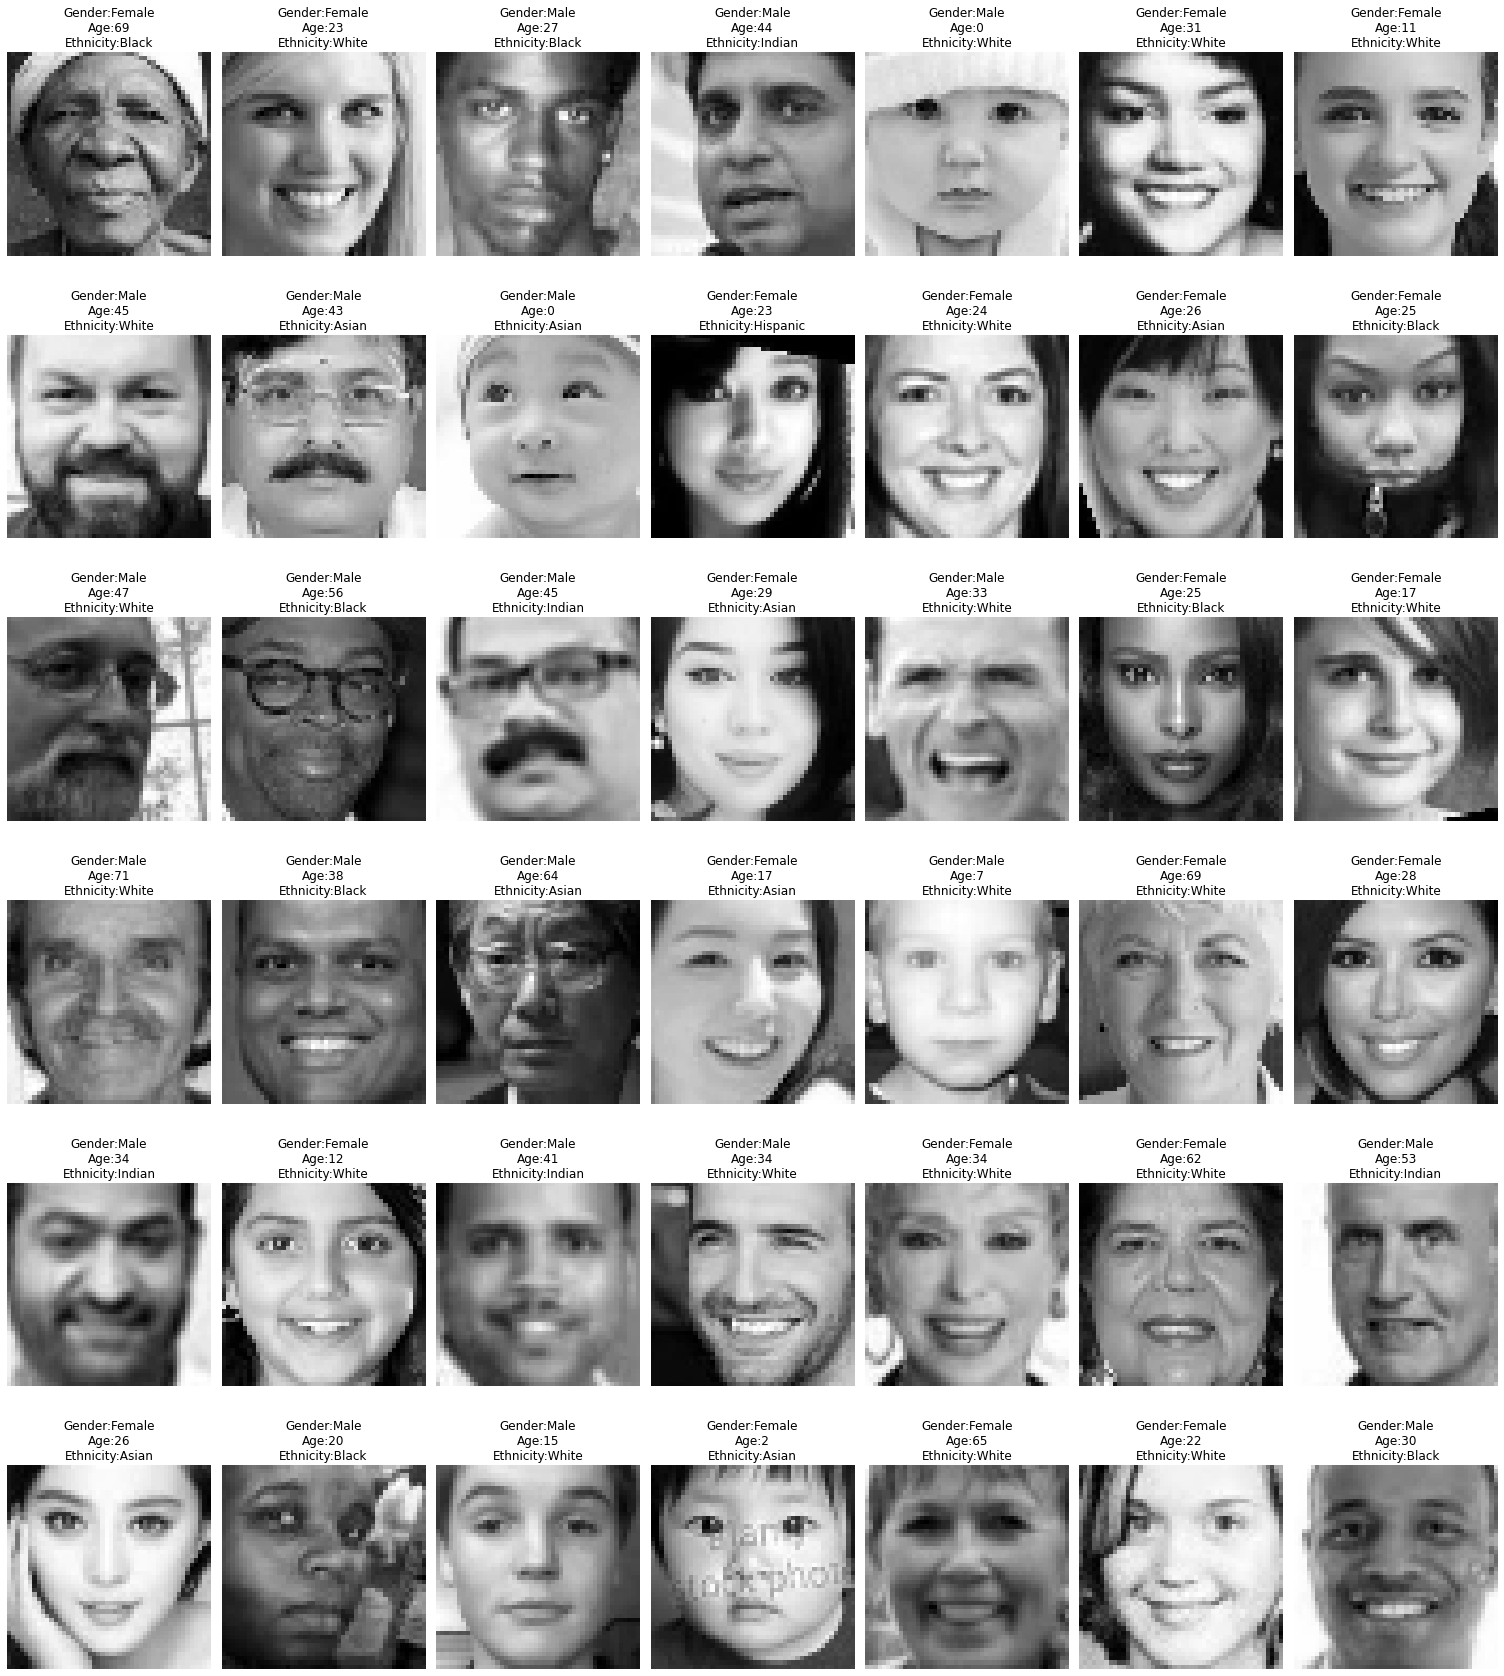

In [ ]:
plot_data(rows=6, cols=7, lower_value=0, upper_value=len(df))

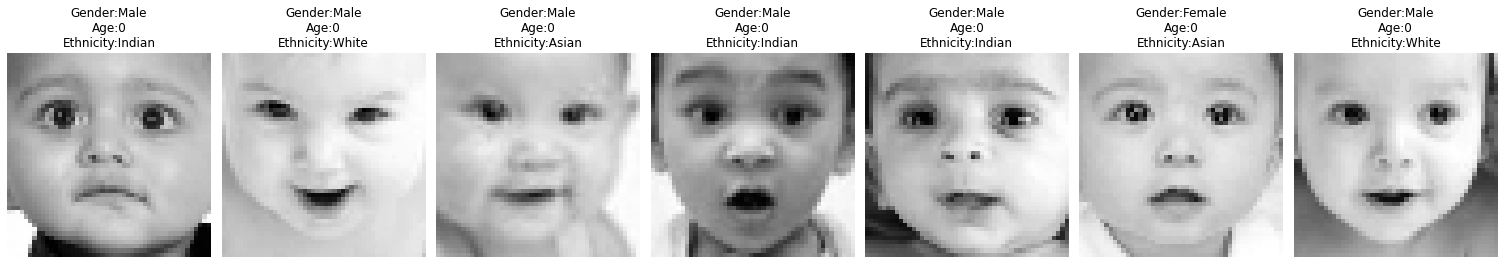

In [ ]:
plot_data(rows=1, cols=7, lower_value=0, upper_value=1000)

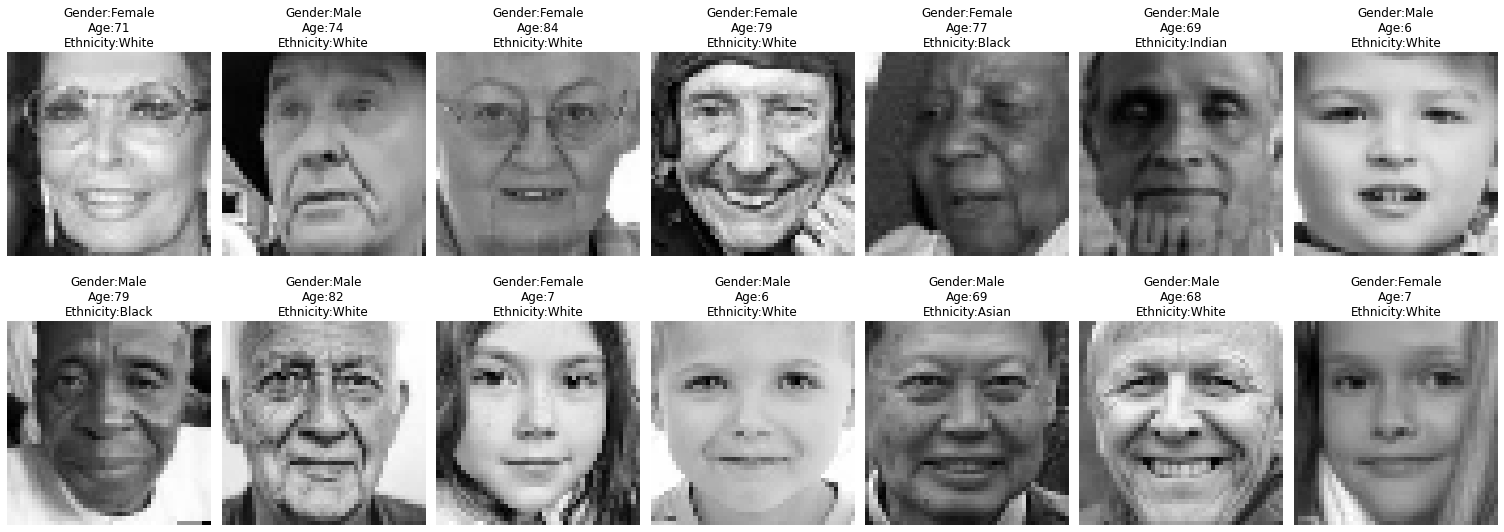

In [ ]:
plot_data(rows=2, cols=7, lower_value=len(df)-2000, upper_value=len(df))

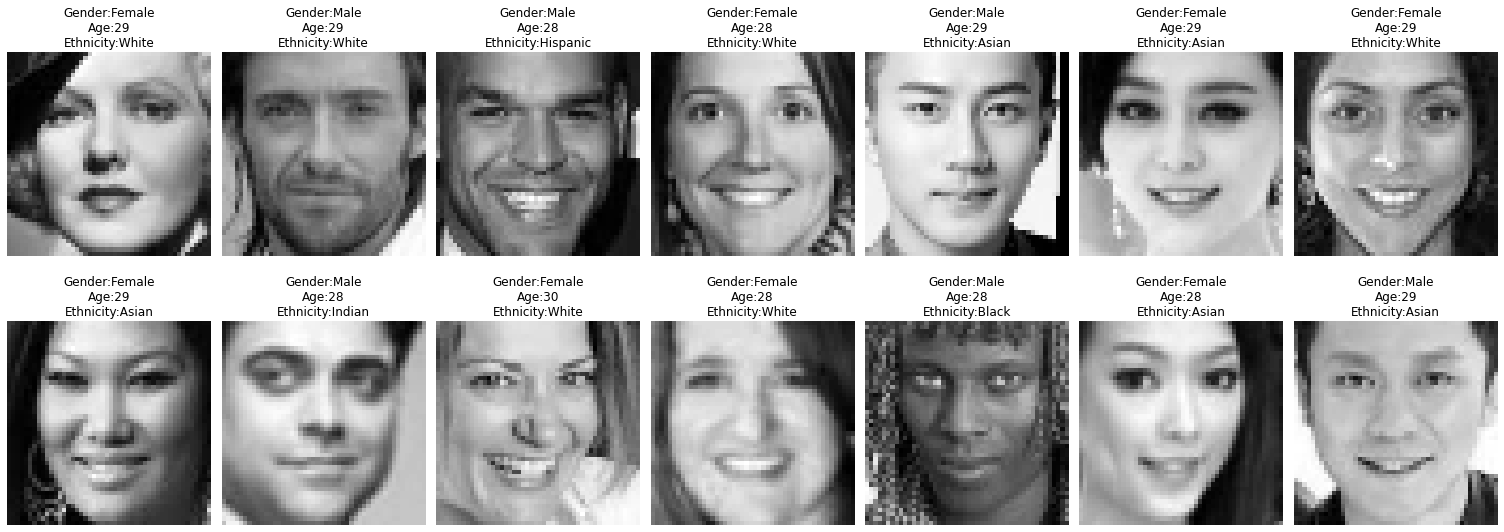

In [ ]:
plot_data(rows=2, cols=7, lower_value=(len(df)-4000)//2, upper_value=len(df)//2)

In [ ]:
psum, psum_sq = 0, 0
# pixel count
image_size = 48
count = len(df) * image_size * image_size

# loop through images
for img in df.pixels:
    psum += np.sum(img)
    psum_sq += np.sum(img**2)

# mean, var and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = np.sqrt(total_var)

# output
print('[Dataset]')
print(f'- mean: {total_mean}')
print(f'- std: {total_std}')
print(f'- var: {total_var}')

[Dataset]
- mean: 125.01632431478356
- std: 59.44005080507268
- var: 3533.119639709621


# Data Fetching

In [ ]:
class get_data(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,i):
        age = df['age'][i]
        eth = df['ethnicity'][i]
        gender = df['gender'][i]
        
        im = cv2.cvtColor(np.array(df['pixels'][i]),cv2.COLOR_GRAY2RGB)
        im = self.transform(im)
        
        age = torch.tensor(age)
        eth = torch.tensor(eth)
        gender = torch.tensor(gender)
        
        return im, float(age), float(eth), float(gender)

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=129) 

print(f'- Number of Datapoints in Training Set: {len(train)}')
print(f'- Number of Datapoints in Test Set: {len(test)}')

- Number of Datapoints in Training Set: 18964
- Number of Datapoints in Test Set: 4741


In [ ]:


# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available:", use_cuda)

if use_cuda:
    BATCH_SIZE=64
else:
    BATCH_SIZE=32
    
print('BATCH_SIZE:', BATCH_SIZE)

CUDA Available: True
BATCH_SIZE: 64


In [ ]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader(get_data(train), batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(get_data(test), batch_size=BATCH_SIZE, shuffle=False, **kwargs)

#Helper Functions for Fine-Tuning the Deep Learning Models

In [ ]:
def bifurcation(model_name):
  model = model_name(pretrained=True)
  param = model.state_dict()
  for i in param.keys():
    print(i)

def selective_finetuning_single_layer(model_name, layer_name):
  model = model_name(pretrained=True)
  for name, param in model.named_parameters():
    if param.requires_grad and layer_name in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  return model.cuda(), torch.nn.CrossEntropyLoss().cuda(), optimizer

In [ ]:
def grad_change(Loss_Function, Optimizer, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def model(choice, Train_Loader, Test_Loader, Epochs, Model_Class=None, Loss_Function=None, Optimizer=None):
  outputs_train=[]
  outputs_test=[]
  if choice=='age':
    for Epoch in range(Epochs):
      running_loss_train=0
      running_loss_test=0
      correct_train=0
      correct_test=0
      for (image, age,_,_) in tqdm(Train_Loader):
        image = image.cuda()
        label = age.type(torch.LongTensor).cuda()
        out = Model_Class(image)
        loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
        running_loss_train += loss.item()
        predicted_train = out.data.max(1, keepdim=True)[1]
        correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
        outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
      with torch.no_grad():
        for (image, age,_,_) in Test_Loader:
          image = image.cuda()
          label = age.type(torch.LongTensor).cuda()
          out = Model_Class(image)
          loss = Loss_Function(out,label)
          running_loss_test += loss.item()
          predicted_test = out.data.max(1, keepdim=True)[1]
          correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
          outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
    return Model_Class, outputs_train, outputs_test
  if choice=='gender':
    for Epoch in range(Epochs):
      running_loss_train=0
      running_loss_test=0
      correct_train=0
      correct_test=0
      for (image, _,_,gen) in tqdm(Train_Loader):
        image = image.cuda()
        label = gen.type(torch.LongTensor).cuda()
        out = Model_Class(image)
        loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
        running_loss_train += loss.item()
        predicted_train = out.data.max(1, keepdim=True)[1]
        correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
        outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
      with torch.no_grad():
        for (image, _,_,gen) in Test_Loader:
          image = image.cuda()
          label = gen.type(torch.LongTensor).cuda()
          out = Model_Class(image)
          loss = Loss_Function(out,label)
          running_loss_test += loss.item()
          predicted_test = out.data.max(1, keepdim=True)[1]
          correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
          outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
    return Model_Class, outputs_train, outputs_test
  if choice=='ethnicity':
    for Epoch in range(Epochs):
      running_loss_train=0
      running_loss_test=0
      correct_train=0
      correct_test=0
      for (image, _,eth,_) in tqdm(Train_Loader):
        image = image.cuda()
        label = eth.type(torch.LongTensor).cuda()
        out = Model_Class(image)
        loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
        running_loss_train += loss.item()
        predicted_train = out.data.max(1, keepdim=True)[1]
        correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
        outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
      with torch.no_grad():
        for (image, _,eth,_) in Test_Loader:
          image = image.cuda()
          label = eth.type(torch.LongTensor).cuda()
          out = Model_Class(image)
          loss = Loss_Function(out,label)
          running_loss_test += loss.item()
          predicted_test = out.data.max(1, keepdim=True)[1]
          correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
          outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
    return Model_Class, outputs_train, outputs_test

In [ ]:
bifurcation(torchvision.models.resnet50)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.0.downsample.1.running_mean
layer1.0.downsample.1.running_var
layer1.0.downsample.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tr

In [ ]:
bifurcation(torchvision.models.vgg19)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.16.weight
features.16.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.23.weight
features.23.bias
features.25.weight
features.25.bias
features.28.weight
features.28.bias
features.30.weight
features.30.bias
features.32.weight
features.32.bias
features.34.weight
features.34.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
bifurcation(torchvision.models.mobilenet_v2)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.0.1.running_mean
features.1.conv.0.1.running_var
features.1.conv.0.1.num_batches_tracked
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.1.conv.2.running_mean
features.1.conv.2.running_var
features.1.conv.2.num_batches_tracked
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.0.1.running_mean
features.2.conv.0.1.running_var
features.2.conv.0.1.num_batches_tracked
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.1.1.running_mean
features.2.conv.1.1.running_var
features.2.conv.1.1.num_batches_tracked
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.2.conv.3.running_mean
features.2.conv.3.running_var


In [ ]:
bifurcation(torchvision.models.alexnet)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


#Age-Wise Classification

In [ ]:
model_resnet, loss_resnet, optim_resnet = selective_finetuning_single_layer(torchvision.models.resnet50, 'fc')
model_resnet ,resnet_train ,resnet_test = model('age',train_loader,test_loader,10,model_resnet, loss_resnet, optim_resnet)

100%|██████████| 297/297 [00:59<00:00,  5.03it/s]


In [ ]:
model_vgg, loss_vgg, optim_vgg = selective_finetuning_single_layer(torchvision.models.vgg19, 'classifier')
model_vgg ,vgg_train ,vgg_test = model('age',train_loader,test_loader,10,model_vgg, loss_vgg, optim_vgg)

100%|██████████| 297/297 [02:02<00:00,  2.43it/s]


In [ ]:
model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2 = selective_finetuning_single_layer(torchvision.models.mobilenet_v2, 'classifier')
model_mobilenet_v2 ,mobilenet_v2_train ,mobilenet_v2_test = model('age',train_loader,test_loader,10,model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2)

100%|██████████| 297/297 [00:29<00:00, 10.08it/s]


In [ ]:
model_alexnet, loss_alexnet, optim_alexnet = selective_finetuning_single_layer(torchvision.models.alexnet, 'classifier')
model_alexnet ,alexnet_train ,alexnet_test = model('age',train_loader,test_loader,10,model_alexnet, loss_alexnet, optim_alexnet)

100%|██████████| 297/297 [00:27<00:00, 10.80it/s]


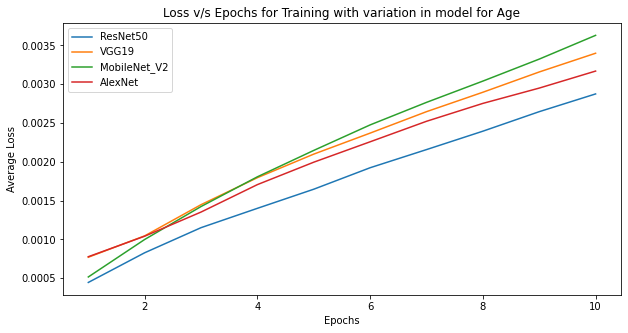

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training with variation in model for Age")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

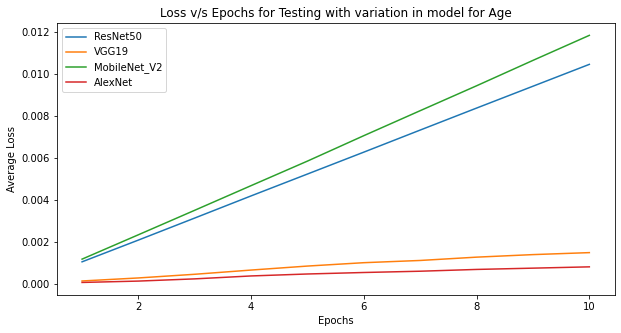

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing with variation in model for Age")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

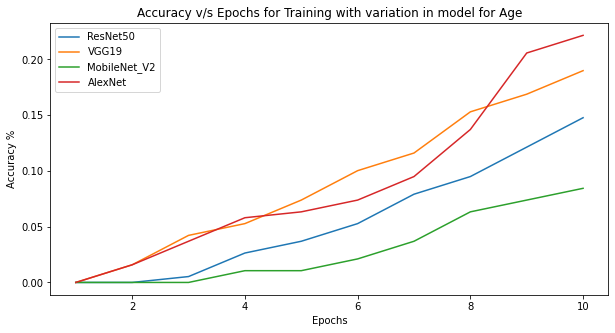

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with variation in model for Age")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

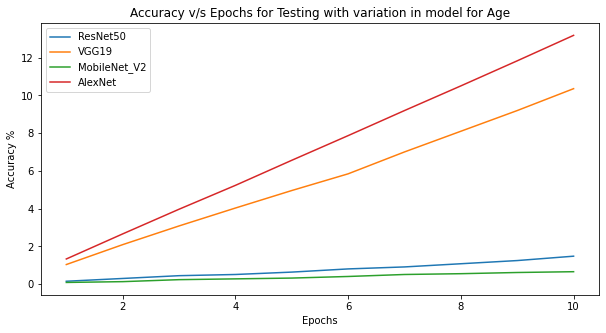

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with variation in model for Age")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

#Ethnicity-Wise Classification

In [ ]:
model_resnet, loss_resnet, optim_resnet = selective_finetuning_single_layer(torchvision.models.resnet50, 'fc')
model_resnet ,resnet_train ,resnet_test = model('ethnicity',train_loader,test_loader,10,model_resnet, loss_resnet, optim_resnet)

100%|██████████| 297/297 [00:59<00:00,  5.03it/s]


In [ ]:
model_vgg, loss_vgg, optim_vgg = selective_finetuning_single_layer(torchvision.models.vgg19, 'classifier')
model_vgg ,vgg_train ,vgg_test = model('ethnicity',train_loader,test_loader,10,model_vgg, loss_vgg, optim_vgg)

100%|██████████| 297/297 [02:02<00:00,  2.43it/s]


In [ ]:
model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2 = selective_finetuning_single_layer(torchvision.models.mobilenet_v2, 'classifier')
model_mobilenet_v2 ,mobilenet_v2_train ,mobilenet_v2_test = model('ethnicity',train_loader,test_loader,10,model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2)

100%|██████████| 297/297 [00:28<00:00, 10.41it/s]


In [ ]:
model_alexnet, loss_alexnet, optim_alexnet = selective_finetuning_single_layer(torchvision.models.alexnet, 'classifier')
model_alexnet ,alexnet_train ,alexnet_test = model('ethnicity',train_loader,test_loader,10,model_alexnet, loss_alexnet, optim_alexnet)

100%|██████████| 297/297 [00:26<00:00, 11.19it/s]


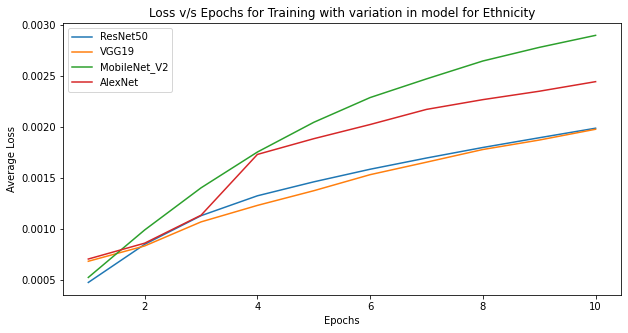

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training with variation in model for Ethnicity")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

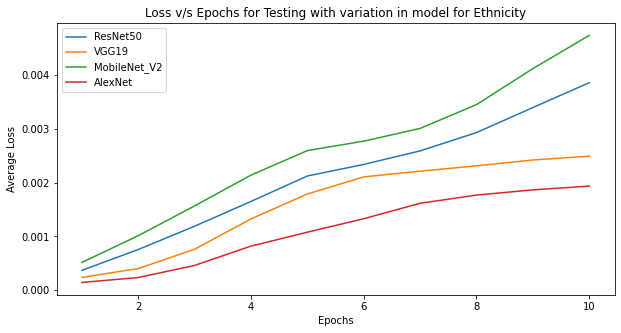

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing with variation in model for Ethnicity")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

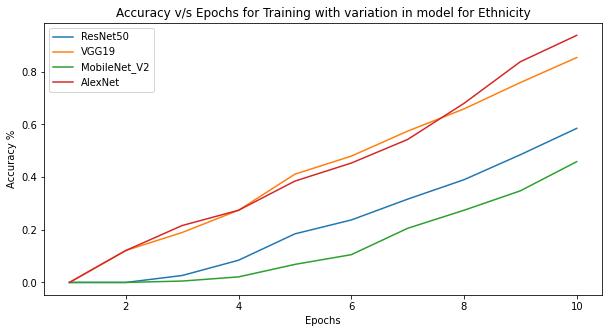

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with variation in model for Ethnicity")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

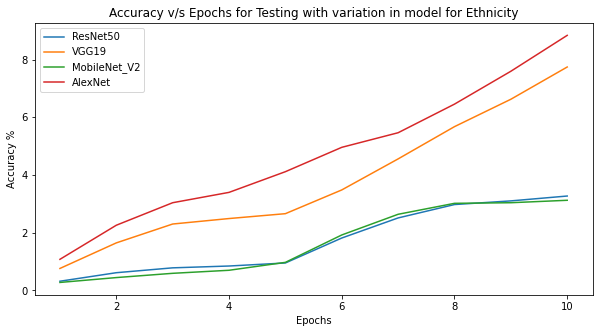

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with variation in model for Ethnicity")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

#Gender-Wise Classification

In [ ]:
model_resnet, loss_resnet, optim_resnet = selective_finetuning_single_layer(torchvision.models.resnet50, 'fc')
model_resnet ,resnet_train ,resnet_test = model('gender',train_loader,test_loader,10,model_resnet, loss_resnet, optim_resnet)

100%|██████████| 297/297 [00:59<00:00,  5.02it/s]


In [ ]:
model_vgg, loss_vgg, optim_vgg = selective_finetuning_single_layer(torchvision.models.vgg19, 'classifier')
model_vgg ,vgg_train ,vgg_test = model('gender',train_loader,test_loader,10,model_vgg, loss_vgg, optim_vgg)

100%|██████████| 297/297 [02:01<00:00,  2.43it/s]


In [ ]:
model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2 = selective_finetuning_single_layer(torchvision.models.mobilenet_v2, 'classifier')
model_mobilenet_v2 ,mobilenet_v2_train ,mobilenet_v2_test = model('gender',train_loader,test_loader,10,model_mobilenet_v2, loss_mobilenet_v2, optim_mobilenet_v2)

100%|██████████| 297/297 [00:28<00:00, 10.30it/s]


In [ ]:
model_alexnet, loss_alexnet, optim_alexnet = selective_finetuning_single_layer(torchvision.models.alexnet, 'classifier')
model_alexnet ,alexnet_train ,alexnet_test = model('gender',train_loader,test_loader,10,model_alexnet, loss_alexnet, optim_alexnet)

100%|██████████| 297/297 [00:26<00:00, 11.03it/s]


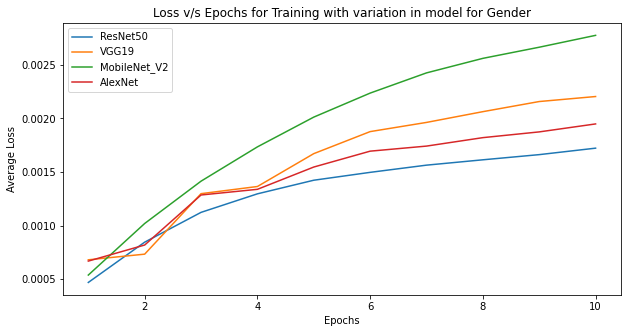

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training with variation in model for Gender")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

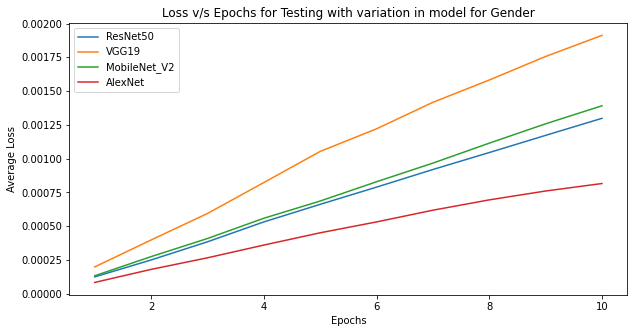

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][1] for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][1] for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing with variation in model for Gender")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

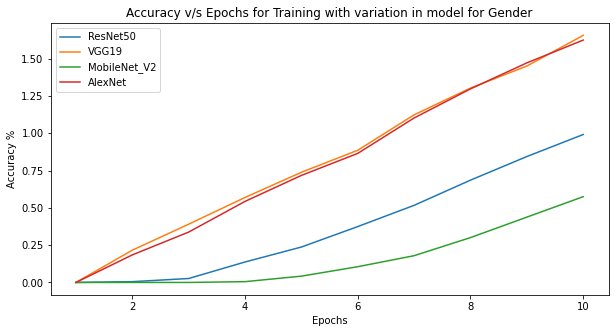

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_train[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_train[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with variation in model for Gender")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

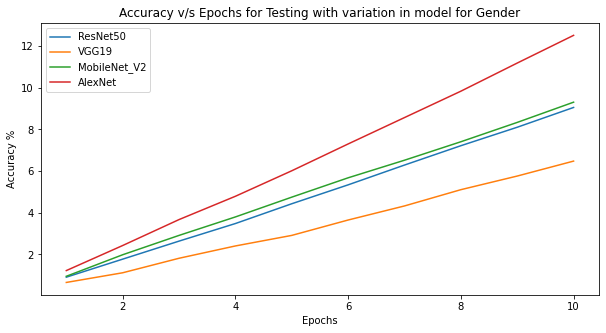

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,11)],[resnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[vgg_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[mobilenet_v2_test[i][2].cpu().numpy() for i in range(0,10)])
plt.plot([j for j in range(1,11)],[alexnet_test[i][2].cpu().numpy() for i in range(0,10)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with variation in model for Gender")
plt.legend(["ResNet50","VGG19","MobileNet_V2","AlexNet"])
plt.show()

#Grad-Cams for understanding the deep insights of Fine-Tuned CNNs

In [ ]:
cd drive/MyDrive/DL_Project_1/gradcam

/content/drive/MyDrive/DL_Project_1/gradcam


In [ ]:
!pip install ttach

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = torchvision.models.resnet50(pretrained=True).cuda()
target_layers = [model.layer4[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[0])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
x = cv2.cvtColor(df.pixels[0],cv2.COLOR_GRAY2RGB)*(1/255.0)

In [ ]:
visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)

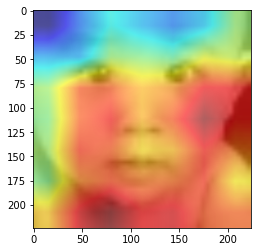

In [ ]:
plt.imshow(visualization)

In [ ]:
model = torchvision.models.vgg19(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[0])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [ ]:
visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)

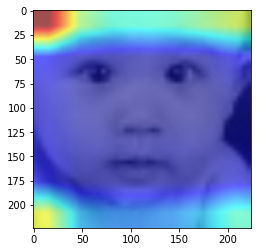

In [ ]:
plt.imshow(visualization)

In [ ]:
model = torchvision.models.alexnet(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[0])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [ ]:
visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)

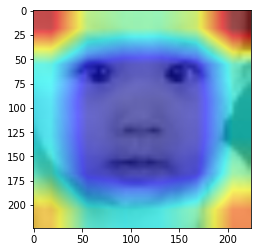

In [ ]:
plt.imshow(visualization)

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[0])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [ ]:
visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)

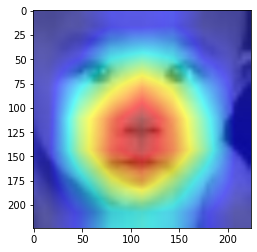

In [ ]:
plt.imshow(visualization)

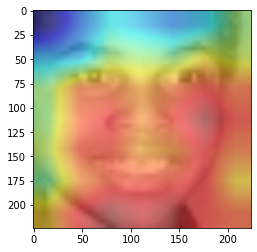

In [ ]:
x = cv2.cvtColor(df.pixels[1251],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.resnet50(pretrained=True).cuda()
target_layers = [model.layer4[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1251])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

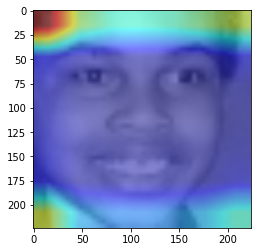

In [ ]:
x = cv2.cvtColor(df.pixels[1251],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.vgg19(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1251])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

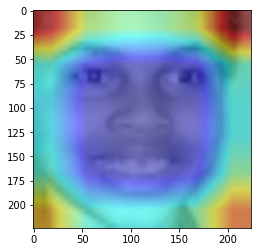

In [ ]:
x = cv2.cvtColor(df.pixels[1251],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.alexnet(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1251])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

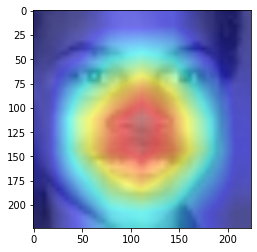

In [ ]:
x = cv2.cvtColor(df.pixels[1251],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.mobilenet_v2(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1251])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

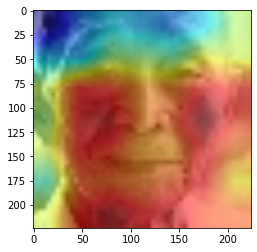

In [ ]:
x = cv2.cvtColor(df.pixels[1292],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.resnet50(pretrained=True).cuda()
target_layers = [model.layer4[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1292])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

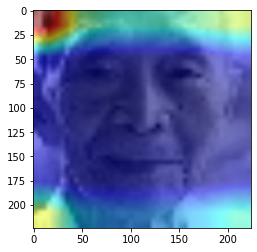

In [ ]:
x = cv2.cvtColor(df.pixels[1292],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.vgg19(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1292])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

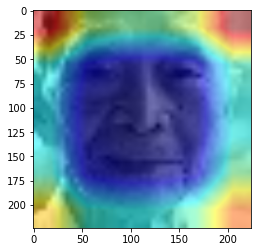

In [ ]:
x = cv2.cvtColor(df.pixels[1292],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.alexnet(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1292])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

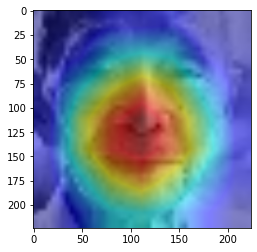

In [ ]:
x = cv2.cvtColor(df.pixels[1292],cv2.COLOR_GRAY2RGB)*(1/255.0)
model = torchvision.models.mobilenet_v2(pretrained=True).cuda()
target_layers = [model.features[-1]]
input_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=125.01632431478356, std=59.44005080507268)
        ])(Image.fromarray(np.uint8(df.pixels[1292])).convert('RGB'))[None]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(cv2.resize(x,(224,224)), grayscale_cam, use_rgb=True)
plt.imshow(visualization)